In [ ]:
# import libraries to be used in the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment. I have the environment set up with all the libraries you need.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [ ]:
# Set the default display option for the notebook.
pd.set_option('display.max_columns', 50)

# Set a default column name format.
def clear_cols(s):
    return s.strip().replace(" ","_")

In [ ]:
# Read data files
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'

# Read the CSV files and rename columns
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [63]:
train.sample()

,Provider,PotentialFraud
2638,PRV54288,No


In [64]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
13127,BENE59418,CLM75454,2009-11-11,2009-11-21,PRV56713,13000,PHY428784,PHY337632,NaN,2009-11-11,4280,1068.0,2009-11-21,189,1970,514,V5861,42821,51884,41071,2869,4148,53081,41519,9671.0,3481.0,NaN,NaN,NaN,NaN


In [65]:
outpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
71121,BENE31248,CLM245214,2009-03-14,2009-03-14,PRV55516,20,PHY341672,NaN,NaN,79579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2752


In [ ]:
# Convert dates to datetime format in Outpatient dataset.
outpatient['ClaimStartDt'] = pd.to_datetime(outpatient['ClaimStartDt'])
outpatient['ClaimEndDt'] = pd.to_datetime(outpatient['ClaimEndDt'])
outpatient['ClaimDuration'] = (outpatient['ClaimEndDt'] - outpatient['ClaimStartDt']).dt.days.astype(int)
outpatient.sample(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimDuration
88087,BENE36150,CLM283111,2009-04-03,2009-04-03,PRV53526,400,PHY369675,PHY369675,NaN,25063,V4581,185,2768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
221706,BENE74685,CLM705101,2009-11-29,2009-11-29,PRV53700,30,PHY375943,NaN,NaN,78959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7905,0
198434,BENE67916,CLM169898,2009-02-01,2009-02-01,PRV53895,500,PHY368630,PHY333735,NaN,72400,7384,7242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,72402,0
271945,BENE88997,CLM228091,2009-03-04,2009-03-04,PRV56114,90,PHY318203,NaN,NaN,2841,V5861,4251,8058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [67]:
outpatient['ClaimDuration'].value_counts()

ClaimDuration
0     453348
20     24312
1      11960
2       4366
14      2735
3       2597
7       2564
4       2238
5       1511
9       1378
6       1306
8       1189
16      1136
10       982
15       975
11       953
13       947
12       903
17       808
18       800
19       727
23         1
21         1
Name: count, dtype: int64

In [68]:
inpatient['Provider'].nunique()

2092

In [ ]:
# Convert dates to datetime format in Inpatient
inpatient['ClaimStartDt'] = pd.to_datetime(inpatient['ClaimStartDt'])
inpatient['ClaimEndDt'] = pd.to_datetime(inpatient['ClaimEndDt'])
inpatient['ClaimDuration'] = (inpatient['ClaimEndDt'] - inpatient['ClaimStartDt']).dt.days.astype(int)
inpatient.sample(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimDuration
24087,BENE99333,CLM58651,2009-07-06,2009-07-19,PRV53226,13000,PHY409694,PHY409694,NaN,2009-07-06,78060,1068.0,2009-07-19,866,0389,29410,5722,E8785,E9289,49121,V462,311,2449,5849,9604.0,NaN,NaN,NaN,NaN,NaN,13
555,BENE13091,CLM50585,2009-05-10,2009-05-15,PRV55812,20000,PHY392116,PHY392116,NaN,2009-05-10,7245,1068.0,2009-05-15,535,8246,E9342,4464,V4365,3659,25060,4254,29281,72402,NaN,8166.0,NaN,NaN,NaN,NaN,NaN,5
37586,BENE148716,CLM49152,2009-04-30,2009-05-05,PRV56575,6000,PHY353156,NaN,NaN,2009-04-30,7802,1068.0,2009-05-05,255,42731,V4364,5853,99812,4580,28529,42781,42830,4589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
36509,BENE144996,CLM64706,2009-08-20,2009-09-01,PRV56808,12000,PHY377125,NaN,NaN,2009-08-20,4280,1068.0,2009-09-01,284,40291,2449,30500,496,4280,4019,5854,412,41404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12


In [ ]:
# Aggregate inpatient data by provider and create the dataframe
df = inpatient.groupby('Provider').agg(
    IPClaimDurationSum = ('ClaimDuration', 'sum'), # sum of claim duration
    IPClaimDurationCount = ('ClaimDuration', 'count') # count of claims
).reset_index()
df

,Provider,IPClaimDurationSum,IPClaimDurationCount
0,PRV51001,25,5
1,PRV51003,320,62
2,PRV51007,16,3
3,PRV51008,8,2
4,PRV51011,5,1
...,...,...,...
2087,PRV57719,55,4
2088,PRV57728,4,1
2089,PRV57729,61,11
2090,PRV57732,58,11


In [71]:
# Check a specefic provider to make sure the number looks good
inpatient.loc[inpatient['Provider'] == 'PRV51001']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimDuration
6904,BENE36012,CLM58316,2009-07-04,2009-07-08,PRV51001,36000,PHY340163,NaN,NaN,2009-07-04,29623,1068.0,2009-07-08,882,29650,2971,3051,V1254,07070,28260,7823,49300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
7611,BENE38773,CLM52334,2009-05-23,2009-05-25,PRV51001,12000,PHY346762,NaN,NaN,2009-05-23,0389,1068.0,2009-05-25,864,0388,5849,2841,2762,7140,E9444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
23936,BENE98831,CLM36844,2009-02-03,2009-02-08,PRV51001,3000,PHY383193,NaN,NaN,2009-02-03,5362,1068.0,2009-02-08,353,56211,5533,0088,5789,53081,27651,7840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
25014,BENE102690,CLM49733,2009-05-04,2009-05-18,PRV51001,42000,PHY383193,PHY378091,PHY389113,2009-05-04,41401,1068.0,2009-05-18,245,4241,42731,4168,2724,4019,42822,2720,45829,53081,NaN,3521.0,2724.0,NaN,NaN,NaN,NaN,14
38474,BENE152088,CLM37205,2009-02-06,2009-02-06,PRV51001,4000,PHY402229,PHY329739,NaN,2009-02-06,80121,1068.0,2009-02-06,062,85222,2724,3310,40390,V4501,V5866,NaN,NaN,NaN,NaN,8659.0,NaN,NaN,NaN,NaN,NaN,0


In [72]:
# Display the datafrom inpatient
df

,Provider,IPClaimDurationSum,IPClaimDurationCount
0,PRV51001,25,5
1,PRV51003,320,62
2,PRV51007,16,3
3,PRV51008,8,2
4,PRV51011,5,1
...,...,...,...
2087,PRV57719,55,4
2088,PRV57728,4,1
2089,PRV57729,61,11
2090,PRV57732,58,11


In [73]:
# Make sure I have the correct number of unique providers from outpatient
outpatient['Provider'].nunique()

5012

In [ ]:
# Aggregate Outpatient data by provider and create the dataframe
out_df = outpatient.groupby('Provider').agg(
    OPClaimDurationSum = ('ClaimDuration', 'sum'),
    OPClaimDurationCount = ('ClaimDuration', 'count')
).reset_index()
out_df

,Provider,OPClaimDurationSum,OPClaimDurationCount
0,PRV51001,11,20
1,PRV51003,165,70
2,PRV51004,213,149
3,PRV51005,1268,1165
4,PRV51007,53,69
...,...,...,...
5007,PRV57759,60,28
5008,PRV57760,7,22
5009,PRV57761,114,82
5010,PRV57762,0,1


In [ ]:
# Merge Inpatient and Outpatient provider totals
provider_claims = pd.merge(
    df,  # Left
    out_df,  # Right
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [ ]:
# The complete data before modeling
provider_claims

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount
0,PRV51001,25.0,5.0,11.0,20.0
1,PRV51003,320.0,62.0,165.0,70.0
2,PRV51004,0.0,0.0,213.0,149.0
3,PRV51005,0.0,0.0,1268.0,1165.0
4,PRV51007,16.0,3.0,53.0,69.0
...,...,...,...,...,...
5405,PRV57759,0.0,0.0,60.0,28.0
5406,PRV57760,0.0,0.0,7.0,22.0
5407,PRV57761,0.0,0.0,114.0,82.0
5408,PRV57762,0.0,0.0,0.0,1.0


In [77]:
# # # Save selected columns to CSV
# provider_claims.to_csv('6 draft.csv', index=False)

In [78]:
provider_claims['IPClaimDurationSum'].sum()

229093.0

In [79]:
provider_claims['OPClaimDurationSum'].sum()

735462.0

In [ ]:
# Then merge with fraud labels (train file)
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)

In [81]:
final_df

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount,PotentialFraud
0,PRV51001,25.0,5.0,11.0,20.0,No
1,PRV51003,320.0,62.0,165.0,70.0,Yes
2,PRV51004,0.0,0.0,213.0,149.0,No
3,PRV51005,0.0,0.0,1268.0,1165.0,Yes
4,PRV51007,16.0,3.0,53.0,69.0,No
...,...,...,...,...,...,...
5405,PRV57759,0.0,0.0,60.0,28.0,No
5406,PRV57760,0.0,0.0,7.0,22.0,No
5407,PRV57761,0.0,0.0,114.0,82.0,No
5408,PRV57762,0.0,0.0,0.0,1.0,No


In [ ]:
# Make the potential fraud column binary
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount,PotentialFraud
0,PRV51001,25.0,5.0,11.0,20.0,0
1,PRV51003,320.0,62.0,165.0,70.0,1
2,PRV51004,0.0,0.0,213.0,149.0,0
3,PRV51005,0.0,0.0,1268.0,1165.0,1
4,PRV51007,16.0,3.0,53.0,69.0,0
...,...,...,...,...,...,...
5405,PRV57759,0.0,0.0,60.0,28.0,0
5406,PRV57760,0.0,0.0,7.0,22.0,0
5407,PRV57761,0.0,0.0,114.0,82.0,0
5408,PRV57762,0.0,0.0,0.0,1.0,0


In [83]:
# Select the features
X = final_df[['IPClaimDurationSum',
              'IPClaimDurationCount',
              'OPClaimDurationSum',
              'OPClaimDurationCount']]

In [84]:
# Select the target
y = final_df['PotentialFraud']

In [85]:
# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [86]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [87]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [88]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # predict probabilities between the 0 and 1 (good for the threshold later)


# Logistic Regression [1]

In [ ]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print(f"Confusion Matrix before manipulating:\n{cm}")

Confusion Matrix before manipulating by adjusting the threshold
Confusion Matrix:
[[964  13]
 [ 65  40]]


In [ ]:
# Flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
# accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')

precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')

recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')

f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.75
Recall: 0.38
F1 Score: 0.51


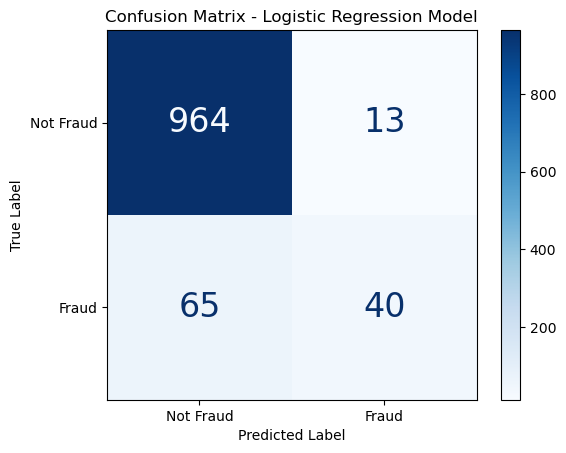

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute and display confusion matrix for Logistic Regression
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 24})
plt.title('Confusion Matrix - Logistic Regression Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

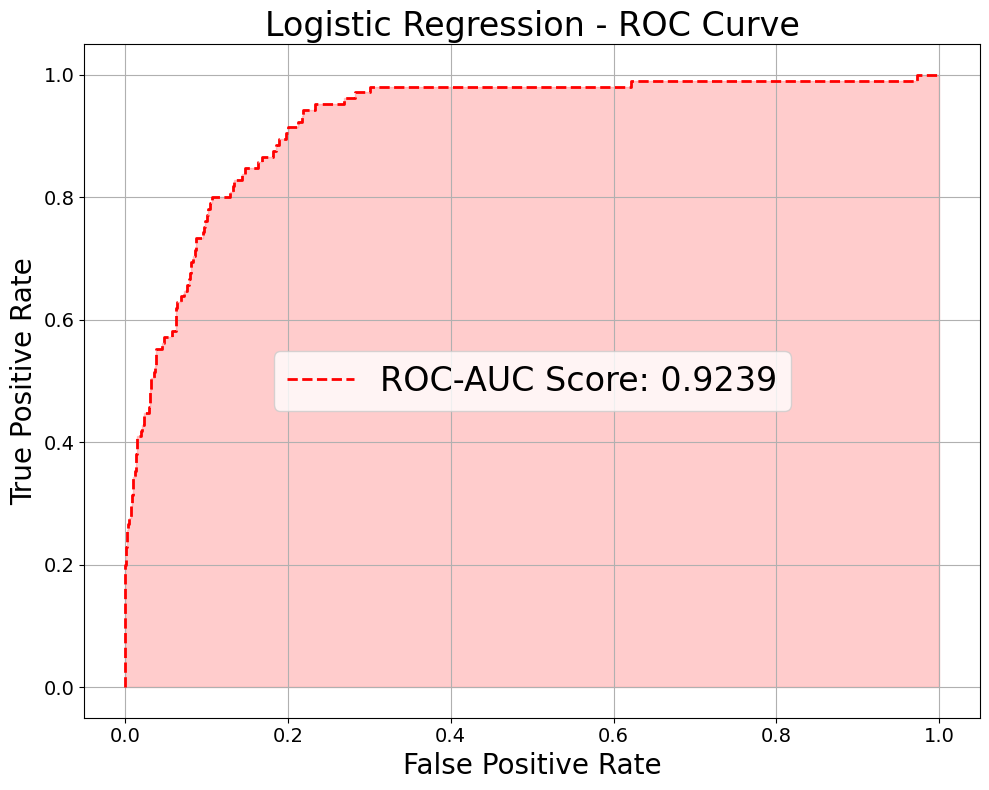

In [ ]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'ROC-AUC Score: {roc_auc:.4}')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red')
ax.set_title('Logistic Regression - ROC Curve', fontsize=24)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=24, loc='best')
plt.tight_layout()
ax.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import auc
# Area Under Curve for Logistic Regression model.
auc(fpr, tpr)

0.9239362479894722

# maybe ignore the cross validation in presentation

# Apply cross validation

In [94]:
from sklearn.model_selection import cross_val_score

# Define Logistic Regression model
model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean auc_roc: {cv_scores.mean():.4f}")


Cross-validation scores: [0.94274886 0.94692222 0.91942451 0.93674872 0.93632453]
Mean auc_roc: 0.9364


#  Hyperparameter Tuning [2]
## Hyperparameter Tuning Using `GridSearchCV`

Checking for the best paramters that will gives the best result in the scoring parameter

In [95]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Display best parameters and roc_auc score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best roc_auc Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best roc_auc Score: 0.9390


In [96]:
from sklearn.metrics import classification_report, roc_auc_score

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)


y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC AUC: {roc_auc:.4f}")

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


Test ROC AUC: 0.9257
              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.81      0.28      0.41       105

    accuracy                           0.92      1082
   macro avg       0.87      0.63      0.69      1082
weighted avg       0.92      0.92      0.91      1082



In [97]:
cm = confusion_matrix(y_test, y_pred)

print("confusion Matrix after GridSearch only:\n",cm)

confusion Matrix after GridSearch only:
 [[970   7]
 [ 76  29]]


In [98]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.92
Precision: 0.81
Recall: 0.28
F1 Score: 0.41


In [99]:
print('Best Logistic Regression Model:\n',best_model)

Best Logistic Regression Model:
 LogisticRegression(C=0.01, max_iter=10000, penalty='l1', solver='liblinear')


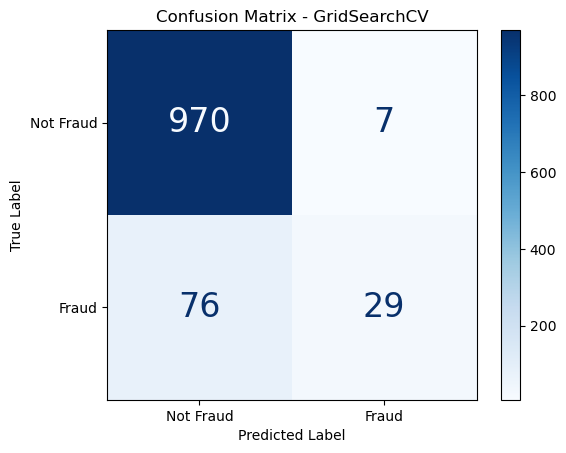

In [100]:
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 24})
plt.title('Confusion Matrix - GridSearchCV')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

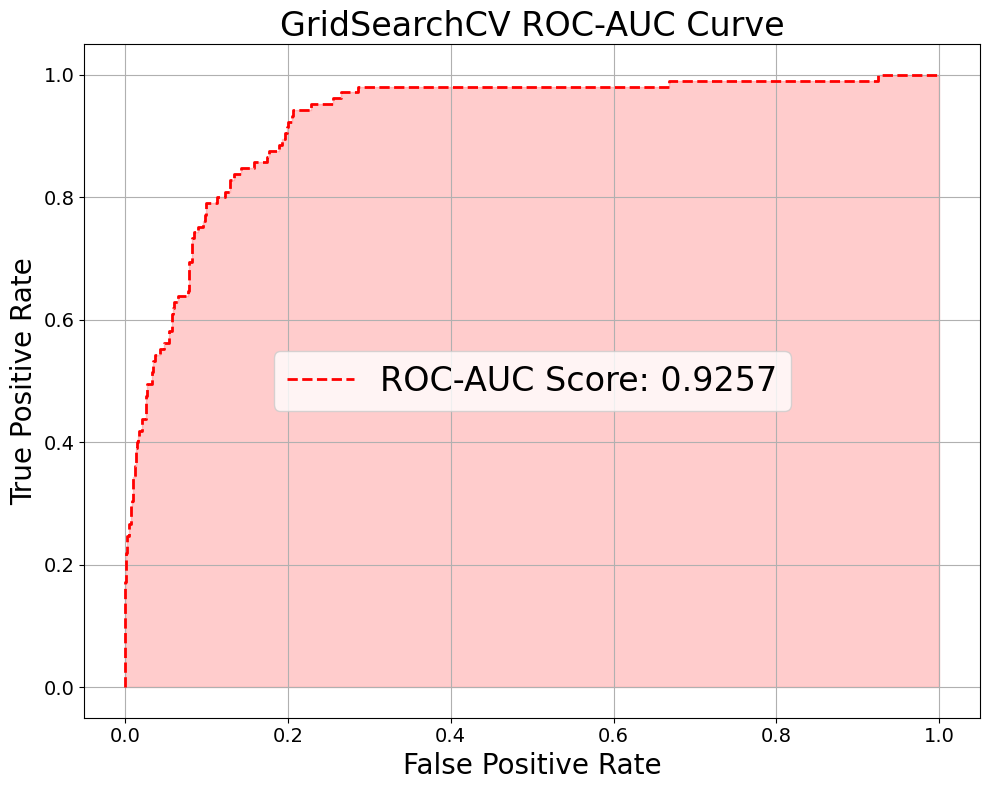

In [101]:
# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=(f'ROC-AUC Score: {roc_auc:.4f}'))
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red') # add color under the curve
ax.set_title('GridSearchCV ROC-AUC Curve', fontsize=24)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=24)
plt.tight_layout()
ax.grid(True)
plt.show()

# 3
# <center>SMOTE

In [102]:
# Checks how the data looks like, before applying a new concept (SMOTE)
final_df.head()

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount,PotentialFraud
0,PRV51001,25.0,5.0,11.0,20.0,0
1,PRV51003,320.0,62.0,165.0,70.0,1
2,PRV51004,0.0,0.0,213.0,149.0,0
3,PRV51005,0.0,0.0,1268.0,1165.0,1
4,PRV51007,16.0,3.0,53.0,69.0,0


In [103]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = final_df.drop(columns=['Provider','PotentialFraud'])
y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print(f"Training data size before SMOTE: {y_train.value_counts()}")
print(f"Training data size after SMOTE: {y_train_resampled.value_counts()}")


Training data size before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
Training data size after SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [104]:
model_after_smote = LogisticRegression(max_iter=10000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=10000)

In [105]:
from sklearn.metrics import classification_report

# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [106]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[885  96]
 [ 14  87]]


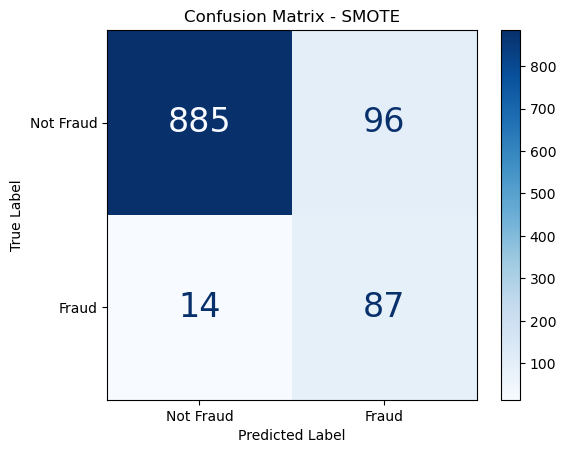

In [107]:
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 24})
plt.title('Confusion Matrix - SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [108]:
# cm = confusion_matrix(y_test, y_pred)
# print('Confusion Matrix smote:\n', cm)

# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.90
Precision: 0.48
Recall: 0.86
F1 Score: 0.61


In [109]:
# print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

### <center>SMOTE AUC_ROC score:

In [110]:
from sklearn.metrics import roc_auc_score

y_proba = model_after_smote.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9611


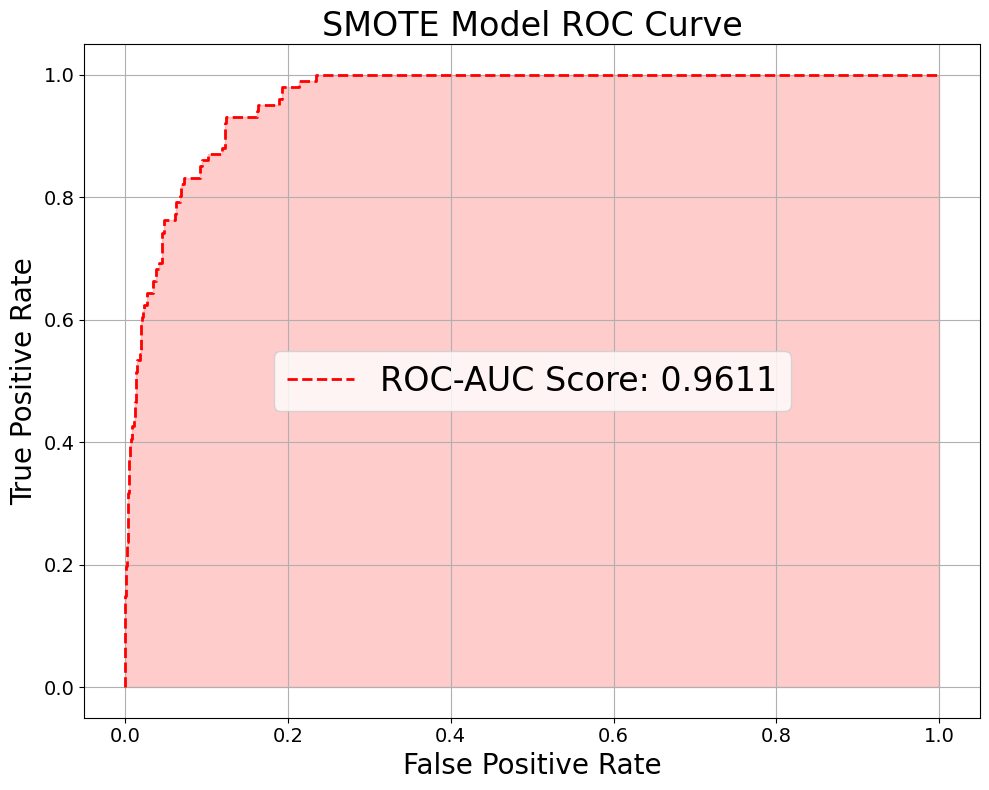

In [111]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'ROC-AUC Score: {roc_auc:.4f}') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red') # add color under the curve
ax.set_title('SMOTE Model ROC Curve', fontsize=24)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=24, loc='best')
plt.tight_layout()
ax.grid(True)
plt.show()

# Not a great improvement
# <center>Grid Search CV
<center>This comes after the smote, so I run the grid search over the smote results

In [112]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [113]:
from sklearn.metrics import roc_auc_score

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)

auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score for the GridSearchCV over the SMOTE: {auc_score:.4f}")


ROC-AUC Score for the GridSearchCV over the SMOTE: 0.9611


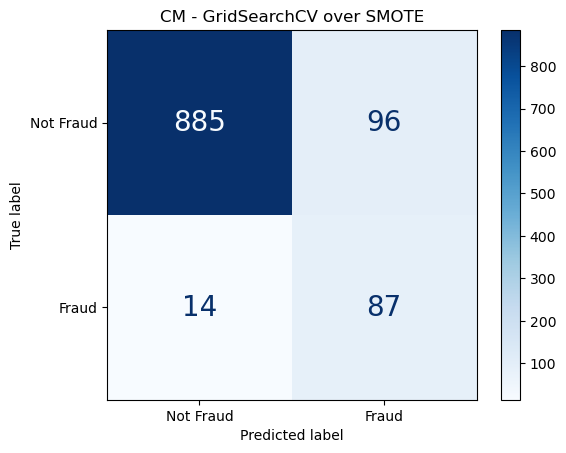

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues', text_kw={'fontsize': 20})
plt.title("CM - GridSearchCV over SMOTE")
plt.show()


In [115]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[885  96]
 [ 14  87]]


In [116]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix after all:\n')
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix after all:

Accuracy: 0.90
Precision: 0.48
Recall: 0.86
F1 Score: 0.61


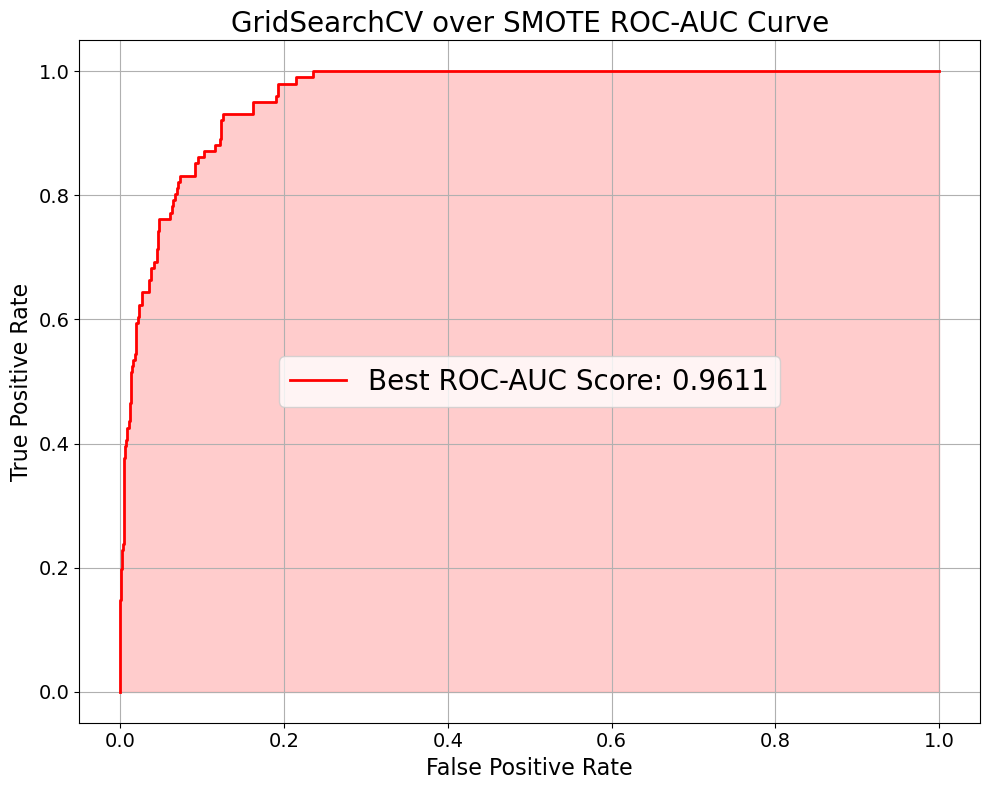

In [117]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r-', lw=2, label=f'Best ROC-AUC Score: {roc_auc:.4f}') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red') # add color under the curve
ax.set_title('GridSearchCV over SMOTE ROC-AUC Curve', fontsize=20) # tile for the chart
ax.set_xlabel('False Positive Rate', fontsize=16) 
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=20, loc='best')
plt.tight_layout()
ax.grid(True)
plt.show()


In [118]:
print(f"ROC-AUC Score for the GridSearchCV over the SMOTE: {auc_score:.4f}")


ROC-AUC Score for the GridSearchCV over the SMOTE: 0.9611


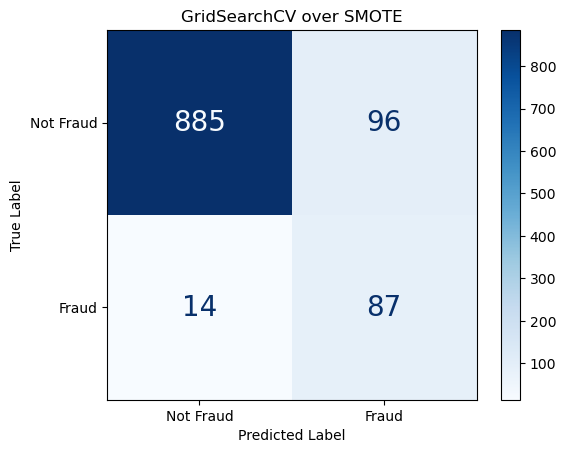

In [119]:
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues, text_kw={'fontsize': 20})
plt.title('GridSearchCV over SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()